Import des bibliothèque necessaires

In [ ]:
# Importations standard
import json
import re
import copy
from datetime import datetime
import os

# Importations de bibliothèques tierces
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# Importations des modules sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Importations nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

# Vérifier et télécharger les ressources nltk si nécessaires
nltk_resources = ['stopwords', 'punkt', 'wordnet']
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}' if resource == 'punkt' else f'corpora/{resource}')
    except LookupError:
        nltk.download(resource)
nltk.download('punkt_tab')

Classe Data pour tous les pré-traitement, vectorisation et réduction de la matrice.

In [33]:
class Data:
    def __init__(self, data = "train.jsonl", test= False, limit=5000, language="french", text_column="texte_annonce"):
        if test==True:
            self.data = (pd.read_json("test.jsonl", lines=True)[["texte_annonce","OGC_FID"]])
        else:
            self.data = (pd.read_json("train.jsonl", lines=True, encoding="UTF-8")[["texte_annonce", "cal_réponse_signalement"]]).iloc[:limit]
            self.data["cal_réponse_signalement"] = self.data["cal_réponse_signalement"].map({"Pris en compte": 0,"Rejete (hors specs)": 1})
        self.text_column = text_column
        self.language = language


    def get_data(self):
        return self.data

    def supprimer_stopwords(self):
        stop_words = stopwords.words(self.language)

        def nettoyer_texte(texte):
            texte = re.sub(r'[^\w\s]', '', texte)  # Retirer la ponctuation
            texte = re.sub(r'\d+', '', texte)      # Retirer les chiffres
            tokens = nltk.word_tokenize(texte.lower())
            return ' '.join([word for word in tokens if word not in stop_words])

        # Appliquer la fonction de nettoyage à la colonne texte
        self.data[self.text_column] = self.data[self.text_column].apply(nettoyer_texte)

    def rien(self, x):
        pass

    def racinisation(self, ignore_stopwords=None):
        stemmer = SnowballStemmer(self.language)
        self.data[self.text_column] = self.data[self.text_column].apply(lambda x: ' '.join([stemmer.stem(word) for word in str(x).split()]))
        self.supprimer_stopwords()

    def lemmatisation(self, mode=None, overwrite=None):
        lemmatizer = WordNetLemmatizer()
        if mode:
            lemmatizer.mode = mode
        if overwrite:
            lemmatizer.overwrite = overwrite
        self.data[self.text_column] = self.data[self.text_column].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in str(x).split()]))
        self.supprimer_stopwords()

    def vectorisation_simple(self, ngram_range=None, max_features=None):
        vectorizer = CountVectorizer()
        if ngram_range:
            vectorizer.ngram_range = ngram_range
        if max_features:
            vectorizer.max_features = max_features
        vect_data = vectorizer.fit_transform(self.data[self.text_column])
        vect_df = pd.DataFrame(vect_data.toarray(), columns=vectorizer.get_feature_names_out())
        self.data = pd.concat([vect_df, self.data.iloc[:, -1]], axis=1)

    def vectorisation_ponderee(self, ngram_range=None, max_features=None, norm=None):
        vectorizer = TfidfVectorizer()
        if ngram_range:
            vectorizer.ngram_range = ngram_range
        if max_features:
            vectorizer.max_features = max_features
        if norm:
            vectorizer.norm = norm
        vect_data = vectorizer.fit_transform(self.data[self.text_column])
        vect_df = pd.DataFrame(vect_data.toarray(), columns=vectorizer.get_feature_names_out())
        self.data = pd.concat([vect_df, self.data.iloc[:, -1]], axis=1)

    def reduction_svd(self, n_components=50, n_iter=None):
        svd = TruncatedSVD()           
        if n_iter:
            svd.n_iter = n_iter
        svd = TruncatedSVD(n_components=n_components)
        svd_result = svd.fit_transform(self.data.iloc[:, :-1])
        self.data = pd.concat([pd.DataFrame(svd_result), self.data.iloc[:, -1]], axis=1)

    def reduction_nmf(self, n_components=50, init=None):
        nmf = NMF(n_components=n_components)
        if init:
            nmf.init = init
        nmf_result = nmf.fit_transform(self.data.iloc[:, :-1])
        self.data = pd.concat([pd.DataFrame(nmf_result), self.data.iloc[:, -1]], axis=1)



Classe global des classifieurs permettant de faire de l'héritage

In [34]:
class Classifieur:
    def __init__(self, data):
        # Chargement et découpage des données
        self.chargement(data)
        self.decoupage()

    def chargement(self, data):
        # Chargement des données et séparation X, y
        self.data = data
        self.X = data.iloc[:, :-1]  # Toutes les colonnes sauf la dernière (X)
        self.y = data.iloc[:, -1]   # Dernière colonne (y)

    def decoupage(self):
        # Découpage en jeu d'entrainement et test
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.X, self.y, test_size=0.6, random_state=0)

    def entrainement(self):
        pass

    def rien(self):
        pass

    def taux_reussite(self):
        # Calcul du taux de réussite
        y_pred = self.classifier.predict(self.X_test)
        accuracy = accuracy_score(self.Y_test, y_pred)
        return f"{accuracy:.3f}"

    def f1_score(self, graph = False):
        # Calcul du F1-score
        from sklearn.metrics import f1_score
        import seaborn as sns
        y_pred = self.classifier.predict(self.X_test)
        f1 = f1_score(self.Y_test, y_pred, average='weighted')

        if graph:
            cm = confusion_matrix(self.Y_test, y_pred)
            
            # Affichage avec seaborn
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.classifier.classes_, yticklabels=self.classifier.classes_)
            plt.title('Matrice de Confusion')
            plt.xlabel('Prédictions')
            plt.ylabel('Vérités')
            plt.show()

        return f"{f1:.3f}"

    def recherche_hyperparametres(self,param_grid):
          # Recherche des meilleurs hyperparamètres avec GridSearchCV
          grid_search = GridSearchCV(
              self.classifier,
              param_grid,
              cv=5,  # Validation croisée 5-fold
              scoring='f1',
          )
          grid_search.fit(self.X_train, self.Y_train) # tres important de preciser le label posit
          self.classifier = grid_search.best_estimator_ # Automatiquement garde le meilleur classifieur
          return grid_search.best_params_
    
    def predict(self, data):
        X = data.iloc[:, :-1]  
        ogc = data.iloc[:, -1] 

        y_pred = self.classifier.predict(X)  
        y_pred = pd.Series(y_pred, name="cal_réponse_signalement")
        y_pred = y_pred.map({0: "Pris en compte", 1: "Rejeté (hors specs)"})

        result = pd.concat([ogc, y_pred], axis=1)
        result.to_csv("submission.csv", index=False)

        return result


In [35]:
from sklearn.naive_bayes import MultinomialNB


class Multinomial(Classifieur):
    def __init__(self, data, alpha = None, fit_prior = None):
        super().__init__(data)
        self.classifier = MultinomialNB()
        if alpha : self.classifier.alpha = alpha
        if fit_prior : self.classifier.fit_prior = fit_prior

    def entrainement(self):
        # Entraînement du modèle avec les données
        self.classifier.fit(self.X_train, self.Y_train)


In [36]:
from sklearn.naive_bayes import BernoulliNB


class Bernoulli(Classifieur):
    def __init__(self, data, alpha = None, fit_prior = None, binarize = None):
        super().__init__(data)

        self.classifier = BernoulliNB()
        if alpha : self.classifier.alpha = alpha
        if fit_prior : self.classifier.fit_prior = fit_prior
        if binarize : self.classifier.binarize = binarize


    def entrainement(self):
        # Entraînement du modèle avec les données
        self.classifier.fit(self.X_train, self.Y_train)

In [37]:
from sklearn.naive_bayes import GaussianNB


class Gaussian(Classifieur):
    def __init__(self, data, var_smoothing = None):
        super().__init__(data)
        self.classifier = GaussianNB()
        if var_smoothing : self.classifier.var_smoothing = var_smoothing

    def entrainement(self):
        # Entraînement du modèle avec les données
        self.classifier.fit(self.X_train, self.Y_train)

In [38]:
from sklearn.linear_model import LogisticRegression

class RegressionLogistique(Classifieur):
    def __init__(self, data, penalty = None, C = None, solver = None, max_iter = None, l1_ratio = None, random_state = None):
        super().__init__(data)
        self.classifier = LogisticRegression()
        if penalty : self.classifier.penalty = penalty
        if C : self.classifier.C = C
        if solver : self.classifier.solver = solver
        if max_iter : self.classifier.max_iter = max_iter
        if l1_ratio : self.classifier.l1_ratio
        if random_state : self.classifier.random_state = random_state

    def entrainement(self):
        self.classifier.fit(self.X_train, self.Y_train)


In [39]:
from sklearn.neighbors import KNeighborsClassifier

class KPlusProchesVoisins(Classifieur):
    def __init__(self, data, n_neighbors = 3, weights = None, algorithm = None, p = None):
        super().__init__(data)

        self.classifier = KNeighborsClassifier()
        if n_neighbors : self.classifier.n_neighbors = n_neighbors
        if weights : self.classifier.weights = weights
        if algorithm : self.classifier.algorithm = algorithm
        if p : self.classifier.p = p

    def entrainement(self):
        self.classifier.fit(self.X_train, self.Y_train)


In [40]:
from sklearn.tree import DecisionTreeClassifier

class ArbreDeDecision(Classifieur):
    def __init__(self, data, criterion = None, max_depth = None, min_samples_split = None, min_samples_leaf = None, max_features = None, ccp_alpha = None, random_state = None):
        super().__init__(data)
        self.classifier = DecisionTreeClassifier()
        if criterion : self.classifier.criterion = criterion
        if max_depth : self.classifier.max_depth = max_depth
        if min_samples_split : self.classifier.min_samples_split = min_samples_split
        if min_samples_leaf : self.classifier.min_samples_leaf = min_samples_leaf
        if max_features : self.classifier.max_features = max_features
        if ccp_alpha : self.classifier.ccp_alpha = ccp_alpha
        if random_state : self.classifier.random_state = random_state

    def entrainement(self):
        self.classifier.fit(self.X_train, self.Y_train)


In [41]:
from sklearn.ensemble import RandomForestClassifier

class ForetAleatoire(Classifieur):
    def __init__(self, data, n_estimators = 100, criterion = None, max_depth = None, min_samples_split = None, min_samples_leaf = None, max_features = None, bootstrap = None, ccp_alpha = None, random_state = 0 ):
        super().__init__(data)
        self.classifier = RandomForestClassifier()
        if n_estimators : self.classifier.n_estimators = n_estimators
        if criterion : self.classifier.criterion = criterion
        if max_depth : self.classifier.max_depth = max_depth
        if min_samples_split : self.classifier.min_samples_split = min_samples_split
        if min_samples_leaf : self.classifier.min_samples_leaf = min_samples_leaf
        if max_features : self.classifier.max_features = max_features
        if bootstrap : self.classifier.bootstrap = bootstrap
        if ccp_alpha : self.classifier.ccp_alpha = ccp_alpha
        if random_state : self.classifier.random_state = random_state

    def entrainement(self):
        self.classifier.fit(self.X_train, self.Y_train)


In [42]:
class Projet() :
    def __init__(self, sequence_data, sequence_classifieur, data_json = "train.jsonl", limit_data = 100, json_resultat = "json_résultat"):

        self.valider_nomenclature(sequence_data, sequence_classifieur)

        

        self.sequence_data = sequence_data
        self.sequence_classifieur = sequence_classifieur
        self.data_json = data_json 
        self.limit_data = limit_data
        self.json_resultat = json_resultat


        self.verif_json_reslutat_name()


        with open("hyperpamètres_classifieur.jsonl","r") as file_1:
            self.hyper_classifieur = json.load(file_1)
        with open("hyperparametres_traitement.jsonl", "r") as file_2:
            self.hyper_data = json.load(file_2)


        if self.sequence_data["vectorisation_simple"] == False and self.sequence_data["vectorisation_ponderee"] == False : self.sequence_data["vectorisation_simple"] = True
        

        ### COMBINAISON DES DATA POSSIBLES ###
        self.combo_data = self.generate_data_hyperparam_combinations()
        self.nb_combo_data = len(self.combo_data)

        print(self.nb_combo_data)

        self.etape_1_sauv = {}
        self.etape_1_2_sauv = {}
        self.etape_1_2_3_sauv = {}
        self.final_res = {}

        self.main_loop()

    def main_loop(self):

        for combinaison in self.combo_data : 
            self.data = Data(data=self.data_json, limit = self.limit_data)
            preprocessing_str = json.dumps(combinaison["preprocessing"], ensure_ascii=False)
            vectorization_str = json.dumps(combinaison["vectorization"], ensure_ascii=False)
            dimension_reduction = json.dumps(combinaison["dimension_reduction"], ensure_ascii=False)
            etape_1_2_str = preprocessing_str + "," + vectorization_str
            etape_1_2_3_str = preprocessing_str + "," + vectorization_str + "," + dimension_reduction


            if etape_1_2_3_str in self.etape_1_2_3_sauv : 
                self.data = copy.deepcopy(self.etape_1_2_3_sauv[etape_1_2_3_str])



            if etape_1_2_str in self.etape_1_2_sauv and etape_1_2_3_str not in self.etape_1_2_3_sauv: 
                self.data = copy.deepcopy(self.etape_1_2_sauv[etape_1_2_str])
                print(self.data.get_data())
                self.apply_etape_3(combinaison["dimension_reduction"], etape_1_2_3_str)

            if (etape_1_2_str not in self.etape_1_2_sauv) and (preprocessing_str in self.etape_1_sauv) and (etape_1_2_3_str not in self.etape_1_2_3_sauv): 
                self.data = copy.deepcopy(self.etape_1_sauv[preprocessing_str])
                self.apply_etape_2(combinaison["vectorization"], etape_1_2_str)
                self.apply_etape_3(combinaison["dimension_reduction"], etape_1_2_3_str)
            
            if etape_1_2_str not in self.etape_1_2_sauv and preprocessing_str not in self.etape_1_sauv and etape_1_2_3_str not in self.etape_1_2_3_sauv:
                self.apply_etape_1(combinaison["preprocessing"], preprocessing_str)
                self.apply_etape_2(combinaison["vectorization"], etape_1_2_str)
                self.apply_etape_3(combinaison["dimension_reduction"], etape_1_2_3_str)


            self.data = self.data.get_data()

            for classifieur_type, booleen_classifier in self.sequence_classifieur.items() : 
                if booleen_classifier : 
                    classifieur = classifieur_type(self.data)
                    classifieur_name = classifieur.__class__.__name__
                    param_classifieur = self.hyper_classifieur[classifieur_name]
                    best_param = classifieur.recherche_hyperparametres(param_classifieur)
                    self.mise_en_forme_final_export_json(combinaison["preprocessing"], combinaison["vectorization"], combinaison["dimension_reduction"], classifieur_name, best_param, classifieur.f1_score())
                    nom_final = preprocessing_str + "," + vectorization_str + "," + dimension_reduction + "," + classifieur_name + "," + json.dumps(param_classifieur, ensure_ascii=False)
                    self.final_res[nom_final] = classifieur.f1_score()



    def mise_en_forme_final_export_json(self, preprocessing, vectorization, dimension_reduction, classifieur_name, best_param, f1_score):
        res = {
            "preprocessing" : preprocessing,
            "vectorization" : vectorization, 
            "dimension_reduction" : dimension_reduction,
            "classifieur_name" : classifieur_name,
            "best_param" : best_param, 
            "f1_score" : f1_score
        }


        if not os.path.exists(self.json_resultat):
            with open(self.json_resultat, 'w', encoding='utf-8') as fichier:
                json.dump([], fichier)

        with open(self.json_resultat, 'r', encoding='utf-8') as fichier:
                data_json_resultat = json.load(fichier)

        data_json_resultat.append(res)

        with open(self.json_resultat, 'w', encoding='utf-8') as fichier:
            json.dump(data_json_resultat, fichier, indent=4, ensure_ascii=False)


        


    def verif_json_reslutat_name(self):
        if os.path.exists(self.json_resultat):
            date_heure_actuelle = datetime.now()
            date_heure_chaine = date_heure_actuelle.strftime("%d-%m %H:%M:%S")
            date_heure_transformee = date_heure_chaine.replace(":", "-").replace(" ", "-")
            self.json_resultat = self.json_resultat + " " + date_heure_transformee
            return 
        else:
            return True  


    def apply_etape_1(self,param, nom):

        if param == None : return 

        if param["method"] == "racinisation" : 
            self.data.racinisation(ignore_stopwords = param["parameters"]["ignore_stopwords"])

        if param["method"] == "lemmatisation" : 
            self.data.lemmatisation(mode = param["parameters"]["mode"], overwrite = param["parameters"]["overwrite"])

        self.etape_1_sauv[nom] = copy.deepcopy(self.data)

    def apply_etape_2(self,  param, nom):
        if param == None : return 

        if param["method"] == "vectorisation_simple" :
            self.data.vectorisation_simple(ngram_range = tuple(param["parameters"]["ngram_range"]), max_features = param["parameters"]["max_features"])
        if param["method"] == "vectorisation_ponderee" : 
            self.data.vectorisation_ponderee(ngram_range = tuple(param["parameters"]["ngram_range"]), max_features = param["parameters"]["max_features"], norm = param["parameters"]["norm"])

        self.etape_1_2_sauv[nom] = copy.deepcopy(self.data)

    def apply_etape_3(self, param, nom):

        if param == None : return 

        if param["method"] == "reduction_svd" : 
            self.data.reduction_svd(n_components = param["parameters"]["n_components"])
        
        if param["method"] == "reduction_nmf" : 
            self.data.reduction_nmf(n_components = param["parameters"]["n_components"], init = param["parameters"]["init"])
        
        self.etape_1_2_3_sauv[nom + "," + json.dumps(param, ensure_ascii=False)] = copy.deepcopy(self.data)



    def generate_data_hyperparam_combinations(self):
        all_combinations = []

        preprocessing_steps = self.hyper_data.get("preprocessing", {})
        vectorization_steps = self.hyper_data.get("vectorization", {})
        reduction_steps = self.hyper_data.get("dimension_reduction", {})

        # Check if all methods for an entire step are disabled
        if not any(self.sequence_data.get(step, False) for step in preprocessing_steps):
            preprocessing_steps = {}
        if not any(self.sequence_data.get(step, False) for step in vectorization_steps):
            vectorization_steps = {}
        if not any(self.sequence_data.get(step, False) for step in reduction_steps):
            reduction_steps = {}

        preprocessing_combos = self._generate_combos_data(preprocessing_steps, "preprocessing")
        vectorization_combos = self._generate_combos_data(vectorization_steps, "vectorization")
        reduction_combos = self._generate_combos_data(reduction_steps, "dimension_reduction")

        if not preprocessing_combos:
            preprocessing_combos = [None]
        if not vectorization_combos:
            vectorization_combos = [None]
        if not reduction_combos:
            reduction_combos = [None]

        for pre in preprocessing_combos:
            for vec in vectorization_combos:
                for red in reduction_combos:
                    all_combinations.append({
                        "preprocessing": pre,
                        "vectorization": vec,
                        "dimension_reduction": red
                    })

        return all_combinations

    def _generate_combos_data(self, steps, step_type):
        """Generate all valid combinations for a specific step type."""
        step_combinations = []
        for step_name, params in steps.items():
            if self.sequence_data.get(step_name, False):
                param_combos = self._generate_param_data_combinations(params)
                for combo in param_combos:
                    step_combinations.append({"method": step_name, "parameters": combo})
        return step_combinations

    def _generate_param_data_combinations(self, params):
        """Generate all combinations of parameters for a given step."""
        if not params:
            return [{}]

        keys, values = zip(*params.items())
        param_combos = [dict(zip(keys, combination)) for combination in product(*values)]
        return param_combos

    def valider_nomenclature(self, sequence_data, sequence_classifieur):
        """
        Méthode pour valider que les dictionnaires respectent la nomenclature attendue.
        """
        # Validation de sequence_data
        expected_sequence_data_keys = [
            "lemmatisation", "racinisation", "vectorisation_simple", 
            "vectorisation_ponderee", "reduction_svd", "reduction_nmf"
        ]
        
        # Vérifier si toutes les clés attendues sont présentes dans sequence_data
        if not all(key in sequence_data for key in expected_sequence_data_keys):
            raise ValueError("Erreur: Le dictionnaire 'sequence_data' doit contenir toutes les clés attendues: " + ", ".join(expected_sequence_data_keys))
        
        # Vérifier que les valeurs sont bien des booléens
        if not isinstance(sequence_data["lemmatisation"], bool) or not isinstance(sequence_data["racinisation"], bool) or \
           not isinstance(sequence_data["vectorisation_simple"], bool) or not isinstance(sequence_data["vectorisation_ponderee"], bool) or \
           not isinstance(sequence_data["reduction_svd"], bool) or not isinstance(sequence_data["reduction_nmf"], bool):
            raise ValueError("Erreur: Les valeurs dans 'sequence_data' doivent être de type booléen.")
        
        # Validation de sequence_classifieur
        expected_classifiers = [
            Multinomial, Bernoulli, Gaussian, RegressionLogistique,
            KPlusProchesVoisins, ArbreDeDecision, ForetAleatoire
        ]
        
        # Vérifier si toutes les clés attendues sont présentes dans sequence_classifieur
        if not all(key in sequence_classifieur for key in expected_classifiers):
            raise ValueError("Erreur: Le dictionnaire 'sequence_classifieur' doit contenir toutes les clés attendues: soit les 7 classifieurs ")
        
        # Vérifier que les valeurs sont bien des booléens
        if not isinstance(sequence_classifieur[Multinomial], bool) or not isinstance(sequence_classifieur[Bernoulli], bool) or \
           not isinstance(sequence_classifieur[Gaussian], bool) or not isinstance(sequence_classifieur[RegressionLogistique], bool) or \
           not isinstance(sequence_classifieur[KPlusProchesVoisins], bool) or not isinstance(sequence_classifieur[ArbreDeDecision], bool) or \
           not isinstance(sequence_classifieur[ForetAleatoire], bool):
            raise ValueError("Erreur: Les valeurs dans 'sequence_classifieur' doivent être de type booléen.")

In [ ]:
###########################################################################################################################################################################
###########################################################################################################################################################################
#########################################################               DEFINITION DES PARAMETRES                ##########################################################
###########################################################################################################################################################################
###########################################################################################################################################################################

###### CHANGER LES PARAMETRES POUR LES SEQUENCE CI-DESSOUS ######

## POUR LES DATA ##
#si les deux méthode d'une étape sont False (ex : lemmatisation et racinisation pour l'étape preprocessing )
#Alors l'étape serat toujours égale à null
sequence_data = {
    "lemmatisation": True,
    "racinisation": True,                                      #########################################################
    "vectorisation_simple": False,                              ### Attention, une des vectorisation doit être cochée ###
    "vectorisation_ponderee": True,                             ###  Vectorisation simple se mettra par defaut sinom  ###
    "reduction_svd": False,                                     #########################################################
    "reduction_nmf": False
}



## POUR LES CLASSIFIEURS ##
sequence_classifieur = {
    Multinomial : False,
    Bernoulli : True,
    Gaussian : True,                       
    RegressionLogistique : False,
    KPlusProchesVoisins : False,
    ArbreDeDecision : False,
    ForetAleatoire : False
}

###### CHANGER SOURCE DES DONNEES ######
data_json = "train.jsonl"
limit_data = 5000


json_resultat = "json_resultat.json"

###########################################################################################################################################################################
#########################################################                   FIN DES DEFINITIONS                ############################################################
###########################################################################################################################################################################


###########################################################################################################################################################################
###########################################################################################################################################################################
#########################################################               lANCEMENT SCRIPT PRINCIPAL                #########################################################
###########################################################################################################################################################################
###########################################################################################################################################################################

projet = Projet(sequence_data = sequence_data, sequence_classifieur = sequence_classifieur, data_json = data_json, limit_data = limit_data, json_resultat = json_resultat)

Exportation Kaggle

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

data = Data(test=True)
data.lemmatisation()
data.vectorisation_ponderee()
data.reduction_nmf(n_components=30)
data_test=data.get_data()
print("data_tester terminé")

data = Data()
data.lemmatisation()
data.vectorisation_ponderee()
data.reduction_nmf(n_components=30)
data_train=data.get_data()
print("data_entainement terminer")

foret = ForetAleatoire(data_train)
foret.recherche_hyperparametres(param_grid)
print("hyperparametre_termine")
print(foret.f1_score())
fichier=foret.predict(data_test)
print("prediction terminer")

### Matrice de confusion

data_entainement terminer


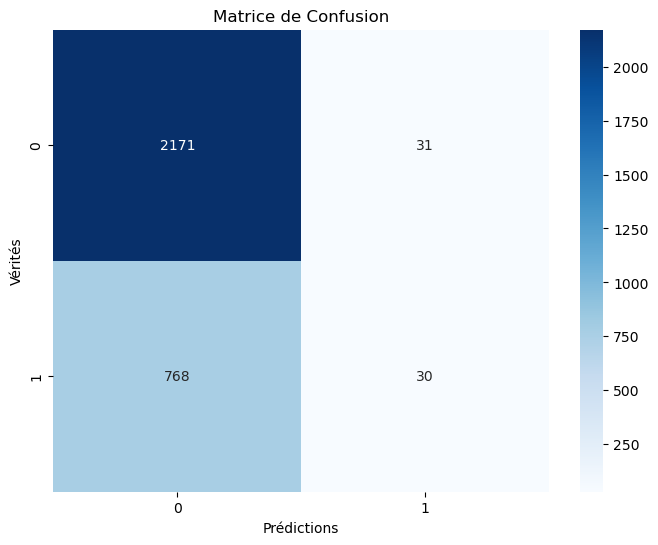

0.639


In [45]:
data = Data()
data.lemmatisation()
data.vectorisation_ponderee()
data.reduction_nmf(n_components=30)
data_train=data.get_data()
print("data_entainement terminer")

foret = ForetAleatoire(data_train)
foret.entrainement()
print(foret.f1_score(graph=True))

### ANALYSE 

In [ ]:
class Analyse():

    def __init__(self):
        self.dossier = "Résultat"

        self.charger_total()  #self.total

        self.nb_individus = len(self.total)

    def charger_total(self):
        self.total = []
        for fichier in os.listdir(self.dossier):
            chemin_fichier = os.path.join(self.dossier, fichier)
            
            if os.path.isfile(chemin_fichier):
                with open(chemin_fichier, 'r', encoding='utf-8') as f:
                    try:
                        data = json.load(f)
                        if isinstance(data, list) and all(isinstance(item, dict) for item in data):
                            self.total.extend(data)
                        else:
                            print(f"Avertissement : {fichier} ne contient pas une liste de dictionnaires.")
                    except json.JSONDecodeError as e:
                        print(f"Erreur lors de la lecture de {fichier} : {e}")
        

analyse = Analyse()